<a href="https://colab.research.google.com/github/vcngeno/Anomaly_Detection_with_ECOD/blob/main/Anomaly_Detection_with_ECOD_Vanessa_Ngeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
df = pd.read_csv("/content/creditcard.csv")

In [ ]:
#Check dataset content
df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [ ]:
#Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442458 entries, 0 to 442457
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Year-Month                    442458 non-null  int64  
 1   Agency Number                 442458 non-null  int64  
 2   Agency Name                   442458 non-null  object 
 3   Cardholder Last Name          442458 non-null  object 
 4   Cardholder First Initial      442458 non-null  object 
 5   Description                   442458 non-null  object 
 6   Amount                        442458 non-null  float64
 7   Vendor                        442458 non-null  object 
 8   Transaction Date              442458 non-null  object 
 9   Posted Date                   442458 non-null  object 
 10  Merchant Category Code (MCC)  442458 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 37.1+ MB


#2. Preprocessing: Parsing Dates & Creating a Cardholder ID

##2.1 Convert transaction date and posted date into proper datetime objects

In [ ]:
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
df["Posted Date"] = pd.to_datetime(df["Posted Date"])

<ipython-input-5-c24d650684d0>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
<ipython-input-5-c24d650684d0>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Posted Date"] = pd.to_datetime(df["Posted Date"])


##2.2 Create a unique cardholder identifier

This will help group transactions by the cardholder in subsequent steps.

In [ ]:
df["Cardholder_ID"] = (
    df["Agency Number"].astype(str) + "_" +
    df["Cardholder Last Name"].astype(str) + "_" +
    df["Cardholder First Initial"].astype(str)
)

#3. Feature Engineering

#3.1 Transaction Amount Deviation

In [ ]:
# Compute each cardholder's average transaction amount
cardholder_avg = df.groupby("Cardholder_ID")["Amount"].mean().rename("Avg_Amount")

# Merge back to main df
df = df.merge(cardholder_avg, on="Cardholder_ID", how="left")

# Compute the deviation
df["Transaction_Amount_Deviation"] = df["Amount"] - df["Avg_Amount"]

##3.2 Daily Spending Ratio

In [ ]:
# Compute total daily spending per cardholder
df["TransactionDate_str"] = df["Transaction Date"].dt.date.astype(str)  # to group by date alone
daily_spend = (
    df.groupby(["Cardholder_ID", "TransactionDate_str"])["Amount"]
    .sum()
    .rename("Total_Daily_Spend")
    .reset_index()
)

# Merge back
df = pd.merge(
    df,
    daily_spend,
    on=["Cardholder_ID", "TransactionDate_str"],
    how="left"
)

# Compute ratio
df["Daily_Spending_Ratio"] = df["Amount"] / df["Total_Daily_Spend"]

##3.3 Transaction Frequency per Cardholder

In [ ]:
cardholder_count = (
    df.groupby("Cardholder_ID")["Amount"]
    .count()
    .rename("Transaction_Frequency_per_Cardholder")
    .reset_index()
)

df = df.merge(cardholder_count, on="Cardholder_ID", how="left")

##3.4 Time Difference Between Transaction and Posted Date

In [ ]:
df["Time_Diff_Transaction_Posted"] = (
    df["Posted Date"] - df["Transaction Date"]
).dt.days

##3.5 Time Between Transactions (Inter-Transaction Time)

In [ ]:
# Sort by cardholder and transaction date
df = df.sort_values(by=["Cardholder_ID", "Transaction Date"])

# Compute difference
df["InterTransaction_Time"] = df.groupby("Cardholder_ID")["Transaction Date"].diff().dt.days

# For the first transaction of each cardholder, this will be NaN.
# You can fill it with 0 or leave as NaN:
df["InterTransaction_Time"] = df["InterTransaction_Time"].fillna(0)

##3.6 Duplicate Transaction Indicator

In [ ]:
# 4.6.1 Create a group ID for potential duplicates
df["dup_group"] = (
    df["Cardholder_ID"].astype(str) + "_" +
    df["TransactionDate_str"].astype(str) + "_" +
    df["Vendor"].astype(str) + "_" +
    df["Amount"].astype(str)
)

# 4.6.2 Count how many times each group appears
dup_count = df.groupby("dup_group")["dup_group"].transform("count")

# 4.6.3 Indicator: 1 if group size > 1, else 0
df["Duplicate_Transaction_Indicator"] = np.where(dup_count > 1, 1, 0)

#4. Final Dataset with New Features
After these steps, we should have a DataFrame containing the original columns plus the six new feature columns:



*   Transaction_Amount_Deviation
*   Daily_Spending_Ratio
*   Transaction_Frequency_per_Cardholder
*   Time_Diff_Transaction_Posted
*   InterTransaction_Time
*   Duplicate_Transaction_Indicator




In [ ]:
df[
    [
        "Year-Month",
        "Agency Number",
        "Cardholder_ID",
        "Amount",
        "Transaction_Amount_Deviation",
        "Daily_Spending_Ratio",
        "Transaction_Frequency_per_Cardholder",
        "Time_Diff_Transaction_Posted",
        "InterTransaction_Time",
        "Duplicate_Transaction_Indicator"
    ]
].head(10)

,Year-Month,Agency Number,Cardholder_ID,Amount,Transaction_Amount_Deviation,Daily_Spending_Ratio,Transaction_Frequency_per_Cardholder,Time_Diff_Transaction_Posted,InterTransaction_Time,Duplicate_Transaction_Indicator
30601,201310,1000,1000_AVERY_K,80.09,-431.030000,1.000000,5,1,0.0,0
47985,201311,1000,1000_AVERY_K,1607.15,1096.030000,1.000000,5,2,34.0,0
53225,201312,1000,1000_AVERY_K,69.57,-441.550000,1.000000,5,1,6.0,0
54741,201312,1000,1000_AVERY_K,68.34,-442.780000,1.000000,5,2,3.0,0
54727,201312,1000,1000_AVERY_K,730.45,219.330000,1.000000,5,2,6.0,0
3581,201307,1000,1000_Abbott_T,2.80,-335.559558,1.000000,113,1,0.0,0
2162,201307,1000,1000_Abbott_T,297.60,-40.759558,1.000000,113,3,4.0,0
6348,201307,1000,1000_Abbott_T,362.37,24.010442,0.160439,113,3,7.0,0
6349,201307,1000,1000_Abbott_T,1068.55,730.190442,0.473101,113,3,0.0,0
6350,201307,1000,1000_Abbott_T,285.00,-53.359558,0.126184,113,3,0.0,0


#5. Next Steps: Unsupervised Detection via ECOD

Now that we have these engineered features, we can now feed them into an ECOD model for anomaly detection.

In [ ]:
#Loading the necessary libraries
!pip install pyod
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.3-py3-none-any.whl size=200466 sha256=b7136bd4f33c71eb6ec049935adef15b955fb11d3b152aef6556bd60c9ba4df3
  Stored in directory: /root/.cache/pip/wheels/2d/60/5b/f74eccd2c9c892a2c298202ca510f10995f9940647fcc2d97f
Successfully built pyod


In [ ]:
from pyod.models.ecod import ECOD

In [ ]:
df.head(10)

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,...,Avg_Amount,Transaction_Amount_Deviation,TransactionDate_str,Total_Daily_Spend,Daily_Spending_Ratio,Transaction_Frequency_per_Cardholder,Time_Diff_Transaction_Posted,InterTransaction_Time,dup_group,Duplicate_Transaction_Indicator
30601,201310,1000,OKLAHOMA STATE UNIVERSITY,AVERY,K,PUMPKIN DECO ORANGE PAIL M EACH|PUMPKIN DECO O...,80.09,TARGET 00023572,2013-10-22,2013-10-23,...,511.120000,-431.030000,2013-10-22,80.09,1.000000,5,1,0.0,1000_AVERY_K_2013-10-22_TARGET 00023572...,0
47985,201311,1000,OKLAHOMA STATE UNIVERSITY,AVERY,K,CRAZY HAIR RUBBER DUCKIES DZ,1607.15,ORIENTAL TRADNG CO,2013-11-25,2013-11-27,...,511.120000,1096.030000,2013-11-25,1607.15,1.000000,5,2,34.0,1000_AVERY_K_2013-11-25_ORIENTAL TRADNG CO_160...,0
53225,201312,1000,OKLAHOMA STATE UNIVERSITY,AVERY,K,GENERAL PURCHASE,69.57,PARTY TIME 2 L.L.C.,2013-12-01,2013-12-02,...,511.120000,-441.550000,2013-12-01,69.57,1.000000,5,1,6.0,1000_AVERY_K_2013-12-01_PARTY TIME 2 L.L.C._69.57,0
54741,201312,1000,OKLAHOMA STATE UNIVERSITY,AVERY,K,GENERAL PURCHASE,68.34,PIZZA HUT,2013-12-04,2013-12-06,...,511.120000,-442.780000,2013-12-04,68.34,1.000000,5,2,3.0,1000_AVERY_K_2013-12-04_PIZZA HUT_68.34,0
54727,201312,1000,OKLAHOMA STATE UNIVERSITY,AVERY,K,GENERAL PURCHASE,730.45,MEEKS GROUP,2013-12-10,2013-12-12,...,511.120000,219.330000,2013-12-10,730.45,1.000000,5,2,6.0,1000_AVERY_K_2013-12-10_MEEKS GROUP_730.45,0
3581,201307,1000,OKLAHOMA STATE UNIVERSITY,Abbott,T,GENERAL PURCHASE,2.80,PIKEPASS REBILLS,2013-07-01,2013-07-02,...,338.359558,-335.559558,2013-07-01,2.80,1.000000,113,1,0.0,1000_Abbott_T_2013-07-01_PIKEPASS REBILLS_2.8,0
2162,201307,1000,OKLAHOMA STATE UNIVERSITY,Abbott,T,AIR TRAVEL,297.60,DELTA AIR 0062335020780,2013-07-05,2013-07-08,...,338.359558,-40.759558,2013-07-05,297.60,1.000000,113,3,4.0,1000_Abbott_T_2013-07-05_DELTA AIR 006233502...,0
6348,201307,1000,OKLAHOMA STATE UNIVERSITY,Abbott,T,068934075 PCS,362.37,XEROX CORPORATION/RBO,2013-07-12,2013-07-15,...,338.359558,24.010442,2013-07-12,2258.61,0.160439,113,3,7.0,1000_Abbott_T_2013-07-12_XEROX CORPORATION/RBO...,0
6349,201307,1000,OKLAHOMA STATE UNIVERSITY,Abbott,T,GENERAL PURCHASE,1068.55,BUSINESS IMAGING SYSTEMS,2013-07-12,2013-07-15,...,338.359558,730.190442,2013-07-12,2258.61,0.473101,113,3,0.0,1000_Abbott_T_2013-07-12_BUSINESS IMAGING SYST...,0
6350,201307,1000,OKLAHOMA STATE UNIVERSITY,Abbott,T,GENERAL PURCHASE,285.00,OK DEPT OF VO-TECH ED,2013-07-12,2013-07-15,...,338.359558,-53.359558,2013-07-12,2258.61,0.126184,113,3,0.0,1000_Abbott_T_2013-07-12_OK DEPT OF VO-TECH ED...,0


##5.1 Prepare the feature matrix

In [ ]:
feature_cols = [
    "Transaction_Amount_Deviation",
    "Daily_Spending_Ratio",
    "Transaction_Frequency_per_Cardholder",
    "Time_Diff_Transaction_Posted",
    "InterTransaction_Time",
    "Duplicate_Transaction_Indicator"
]

X = df[feature_cols].values  # This will be a NumPy array


##5.2 Fit the ECOD model

While trying to fit the model at first, I got an error and decided to check if one of the feature columns had infinite values.

ECOD (and most scikit-learn models) cannot handle infinite or NaN values. Cleaning these ensures the model can train without error.

In [ ]:
# A quick way to see if there are infinite values
mask_inf = df[feature_cols].isin([np.inf, -np.inf]).any(axis=1)
if mask_inf.any():
    print("Rows with infinite values:")
    print(df[mask_inf][feature_cols])
else:
    print("No infinite values found.")


Rows with infinite values:
        Transaction_Amount_Deviation  Daily_Spending_Ratio  \
280240                   -192.247093                   inf   
283923                   -693.567093                  -inf   
265140                   -142.629321                  -inf   
265143                    -40.929321                   inf   
381380                   -418.011951                  -inf   
...                              ...                   ...   
249412                   -686.672286                  -inf   
251348                   -458.094122                   inf   
251625                   -495.014122                  -inf   
251430                   -458.604122                   inf   
251624                   -494.504122                  -inf   

        Transaction_Frequency_per_Cardholder  Time_Diff_Transaction_Posted  \
280240                                    86                             2   
283923                                    86                            

In [ ]:
df[feature_cols].max()


,0
Transaction_Amount_Deviation,1294818.645
Daily_Spending_Ratio,inf
Transaction_Frequency_per_Cardholder,10137.000
Time_Diff_Transaction_Posted,183.000
InterTransaction_Time,367.000
Duplicate_Transaction_Indicator,1.000


In [ ]:
# The Daily Spending Ratio column has infinite values, therefore, to solve this;
# We will Replace or fill any missing or zero daily spend to avoid division by zero
df["Total_Daily_Spend"] = df["Total_Daily_Spend"].fillna(0)

# This mask identifies rows where the denominator is zero
zero_spend_mask = df["Total_Daily_Spend"] == 0

# We want a ratio of 0 for these cases
df["Daily_Spending_Ratio"] = np.where(
    zero_spend_mask,
    0,   # set ratio to 0 if denominator is 0
    df["Amount"] / df["Total_Daily_Spend"]  # normal ratio otherwise
)

# Ensure no infinity remains
df["Daily_Spending_Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
df["Daily_Spending_Ratio"].fillna(0, inplace=True)

<ipython-input-20-22945b9076ef>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Daily_Spending_Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-20-22945b9076ef>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [ ]:
print("Max values after fix:")
print(df[[
    "Transaction_Amount_Deviation",
    "Daily_Spending_Ratio",
    "Transaction_Frequency_per_Cardholder",
    "Time_Diff_Transaction_Posted",
    "InterTransaction_Time",
    "Duplicate_Transaction_Indicator"
]].max())

mask_inf_again = df[["Daily_Spending_Ratio"]].isin([np.inf, -np.inf]).any(axis=1)
print("Any remaining inf?", mask_inf_again.any())

mask_nan_again = df[["Daily_Spending_Ratio"]].isna().any(axis=1)
print("Any remaining NaN?", mask_nan_again.any())


Max values after fix:
Transaction_Amount_Deviation            1.294819e+06
Daily_Spending_Ratio                    2.878645e+16
Transaction_Frequency_per_Cardholder    1.013700e+04
Time_Diff_Transaction_Posted            1.830000e+02
InterTransaction_Time                   3.670000e+02
Duplicate_Transaction_Indicator         1.000000e+00
dtype: float64
Any remaining inf? False
Any remaining NaN? False


##5.3 Retry to Fit the ECOD Model

In [ ]:
from pyod.models.ecod import ECOD

feature_cols = [
    "Transaction_Amount_Deviation",
    "Daily_Spending_Ratio",
    "Transaction_Frequency_per_Cardholder",
    "Time_Diff_Transaction_Posted",
    "InterTransaction_Time",
    "Duplicate_Transaction_Indicator"
]

X = df[feature_cols].values

ecod = ECOD(contamination=0.05)
ecod.fit(X)  # Should no longer raise the ValueError


ECOD(contamination=0.05, n_jobs=1)

The contamination parameter is set at(often 0.05 = 5%), indicating the expected proportion of outliers in the dataset.

contamination=0.05 guides the model to label ~5% of transactions as outliers, which is often a domain-driven assumption for how many transactions might be anomalous.

##5.4 Get outlier scores and predictions
After fitting, ECOD can generate:

A continuous outlier score (the higher, the more likely the transaction is an outlier).
A binary prediction label (0 = normal, 1 = outlier).

In [ ]:
# Outlier scores (higher = more anomalous)
y_scores = ecod.decision_function(X)

# Labels (0 = normal, 1 = outlier), using the threshold derived from contamination
y_pred = ecod.predict(X)

# Store them back into the DataFrame for convenience
df["ECOD_Score"] = y_scores
df["ECOD_Label"] = y_pred


##5.5 Examine the outlier score distribution

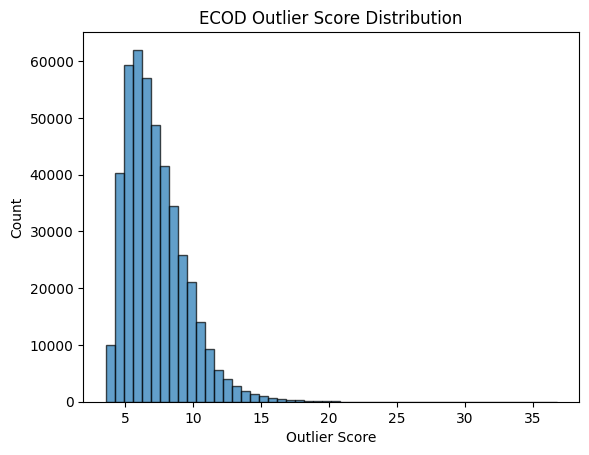

ECOD Threshold (based on contamination): 11.258030911164367


In [ ]:
plt.hist(y_scores, bins=50, edgecolor='k', alpha=0.7)
plt.title("ECOD Outlier Score Distribution")
plt.xlabel("Outlier Score")
plt.ylabel("Count")
plt.show()

# We can also examine the threshold that PyOD used:
print("ECOD Threshold (based on contamination):", ecod.threshold_)


Most transactions cluster between scores of roughly 3 and 8.

This indicates that the majority of data is considered “relatively normal,” with scores in that moderate range.
Right‐skewed / heavy tail beyond about 10.

A smaller number of transactions extend far into higher outlier scores (15–35).
These extreme‐score transactions are the ones ECOD deems most anomalous.

No large “gap” in the distribution.

Instead of a clear “elbow” or big jump, the score distribution tapers gradually.

This could mean there is no obvious natural cutoff and might have to rely on the preset contamination rate (e.g., 5%) or domain knowledge to decide where to draw the outlier threshold.

## 5.6 Summarize normal vs. outlier groups

In [ ]:
# Using the default label from contamination
normal_df = df[df["ECOD_Label"] == 0]
outlier_df = df[df["ECOD_Label"] == 1]

print("Normal Group Size:", len(normal_df))
print("Outlier Group Size:", len(outlier_df))

summary_table = pd.DataFrame({
    "Normal_Mean": normal_df[feature_cols].mean(),
    "Outlier_Mean": outlier_df[feature_cols].mean(),
    "Normal_Std": normal_df[feature_cols].std(),
    "Outlier_Std": outlier_df[feature_cols].std(),
})

summary_table


Normal Group Size: 420335
Outlier Group Size: 22123


,Normal_Mean,Outlier_Mean,Normal_Std,Outlier_Std
Transaction_Amount_Deviation,-15.508377,294.657765,816.013315,2.055401e+04
Daily_Spending_Ratio,0.520105,0.465909,0.472879,6.500713e+14
Transaction_Frequency_per_Cardholder,737.544071,1316.660444,1771.197624,2.720344e+03
Time_Diff_Transaction_Posted,1.796053,3.409664,1.088621,5.157856e+00
InterTransaction_Time,2.475373,17.298965,5.309816,3.425900e+01
Duplicate_Transaction_Indicator,0.052320,0.163585,0.222672,3.699073e-01


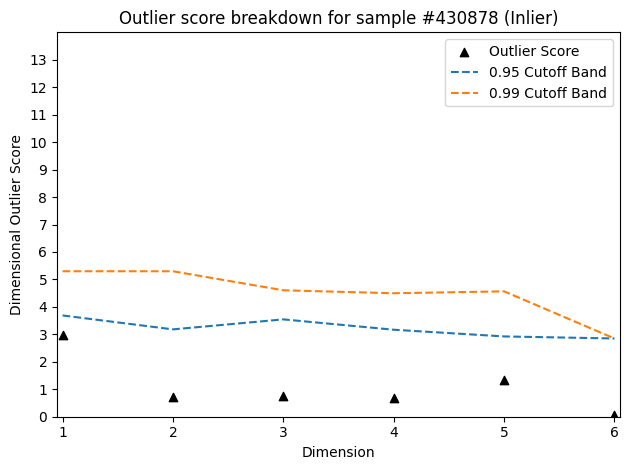

Explanation for index 430877:
None
--------------------------------------------------


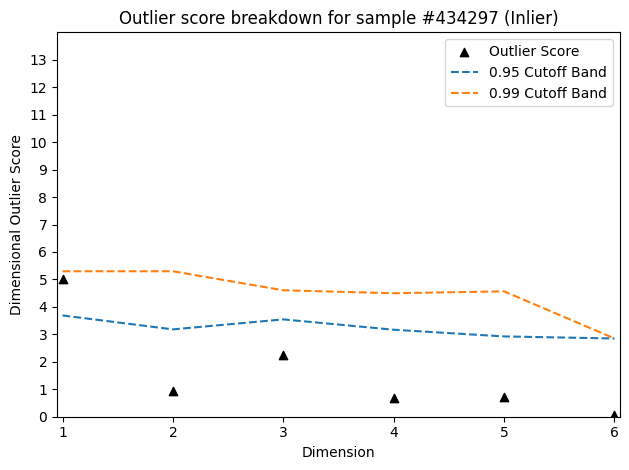

Explanation for index 434296:
None
--------------------------------------------------


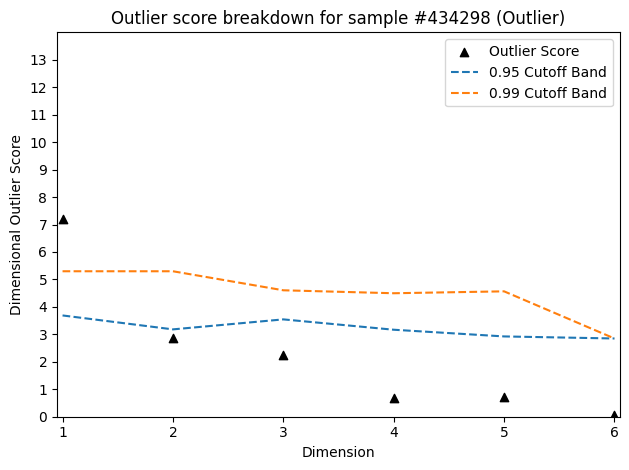

Explanation for index 434297:
None
--------------------------------------------------


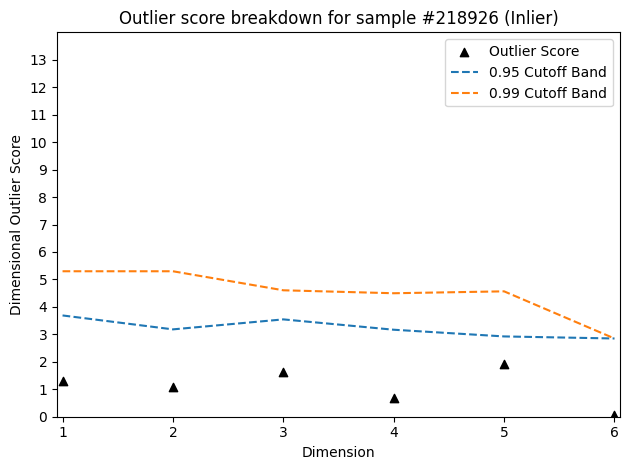

Explanation for index 218925:
None
--------------------------------------------------


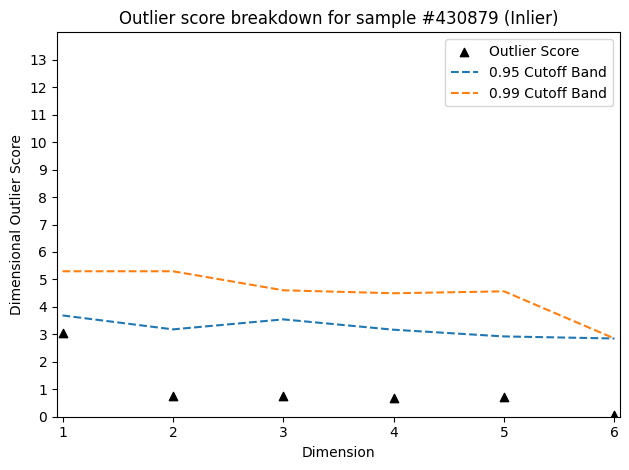

Explanation for index 430878:
None
--------------------------------------------------


In [ ]:
# Let's find the top 5 transactions with the highest ECOD scores
df_sorted = df.sort_values("ECOD_Score", ascending=False)
top_outliers = df_sorted.head(5)

top_indices = top_outliers.index.tolist()

for idx in top_indices:
    explanation = ecod.explain_outlier(idx)
    print(f"Explanation for index {idx}:")
    print(explanation)
    print("-" * 50)


This per‐feature breakdown clarifies why a transaction is or isn’t flagged: each bar (triangle) shows whether a feature is near the normal range or at an extreme tail.

In this case, no dimension is out of bounds, so the transaction is deemed normal despite the other samples in the top‐5 list being actual anomalies.